In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from transformers import BertTokenizer, BertModel
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()  # Suppress warnings from transformers

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.nn import Parameter
import pandas as pd
import numpy as np
import string
import time

from collections import Counter
from tqdm import tqdm

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!pip install -U datasets
from datasets import load_dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data Preprocessing
### Converts raw text data from HuggingFace into a cleaned format suitable for BERT and other NLP models

In [ ]:
class TextPreprocessor:
    # INITIALIZE WITH BERT TOKENIZER
    def __init__(self, pretrained_model_name='bert-base-uncased', max_len=50):
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
        self.max_len = max_len
        # Create translation table once during initialization
        self.punctuation_translator = str.maketrans('', '', string.punctuation)

    # TEXT CLEANING - REMOVE HTML TAGS AND PUNCTUATION, CONVERT TO LOWERCASE
    def clean_text(self, text):
        # Skip BeautifulSoup for simple cases
        text = re.sub(r'<[^>]+>', '', text)  # Faster than BeautifulSoup for basic HTML
        return text.lower().translate(self.punctuation_translator)

    # Vectorized version of clean_text for processing entire series at once
    def clean_text_batch(self, text_series):
        # Process the entire series at once using vectorized operations
        text_series = text_series.str.replace(r'<[^>]+>', '', regex=True)
        text_series = text_series.str.lower()
        text_series = text_series.apply(lambda x: x.translate(self.punctuation_translator))
        return text_series

    # ENCODE TEXT WITH BERT TOKENIZER
    def tokenize_and_encode(self, texts):
        return self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

    # PREPROCESS USING ALL ABOVE METHODS
    def preprocess_dataset(self, df_or_dfs, text_column, label_column):
        if not isinstance(df_or_dfs, list) or len(df_or_dfs) != 3:
            raise ValueError("df_or_dfs must be a DataFrame or a list of DataFrames of size 3.")

        train_df, val_df, test_df = df_or_dfs

        print("Cleaning text data...")
        # Use vectorized operations instead of apply
        train_df[text_column] = self.clean_text_batch(train_df[text_column])
        val_df[text_column] = self.clean_text_batch(val_df[text_column])
        test_df[text_column] = self.clean_text_batch(test_df[text_column])

        print("Tokenizing and encoding text data...")
        # Convert to lists only once before tokenization
        train_texts = train_df[text_column].tolist()
        val_texts = val_df[text_column].tolist()
        test_texts = test_df[text_column].tolist()

        train_encodings = self.tokenize_and_encode(train_texts)
        val_encodings = self.tokenize_and_encode(val_texts)
        test_encodings = self.tokenize_and_encode(test_texts)

        # Convert labels to tensors directly from original dataframes
        train_labels = torch.tensor(train_df[label_column].values)
        val_labels = torch.tensor(val_df[label_column].values)
        test_labels = torch.tensor(test_df[label_column].values)

        print(f"Train set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples")
        print(f"Test set: {len(test_df)} samples")

        return (train_encodings['input_ids'], train_encodings['attention_mask'], train_labels,
                val_encodings['input_ids'], val_encodings['attention_mask'], val_labels,
                test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Quaternion Classes

In [ ]:
class Quaternion:
    # INITIALIZE TENSOR THAT WILL BE SPLIT INTO QUATERNION COMPONENTS
    def __init__(self, tensor):
        # ASSUME COMPONENTS CONCATENATED ALONG LAST DIMENSION
        self.tensor = tensor
        # Store the shape for faster processing
        self.quat_dim = self.tensor.shape[-1] // 4
        # Split only when needed (lazy evaluation)
        self._components = None

    @property
    def components(self):
        # Lazy initialization of components
        if self._components is None:
            self._components = torch.split(self.tensor, self.quat_dim, dim=-1)
        return self._components

    @property
    def r(self):
        return self.components[0]

    @property
    def i(self):
        return self.components[1]

    @property
    def j(self):
        return self.components[2]

    @property
    def k(self):
        return self.components[3]

    @classmethod
    # CREATE QUATERNION FROM INPUT R, I, J, K COMPONENTS
    def from_components(cls, r, i, j, k):
        tensor = torch.cat([r, i, j, k], dim=-1)
        return cls(tensor)

    # COMPUTE HAMILTON PRODUCT BETWEEN TWO QUATERNIONS
    def hamilton_product(self, other):
        r1, i1, j1, k1 = self.r, self.i, self.j, self.k
        r2, i2, j2, k2 = other.r, other.i, other.j, other.k

        # Simplified condition check
        is_matrix_mul = (r1.dim() == 2 and r2.dim() == 2 and r1.shape[-1] == r2.shape[-2])

        if is_matrix_mul:
            # Matrix multiplication - pre-allocate output tensors to optimize memory
            batch_size = r1.size(0)
            output_size = r2.size(-1)

            r = torch.zeros(batch_size, output_size, device=r1.device)
            i = torch.zeros(batch_size, output_size, device=r1.device)
            j = torch.zeros(batch_size, output_size, device=r1.device)
            k = torch.zeros(batch_size, output_size, device=r1.device)

            # Use in-place operations where possible
            torch.matmul(r1, r2, out=r)
            r.sub_(torch.matmul(i1, i2))
            r.sub_(torch.matmul(j1, j2))
            r.sub_(torch.matmul(k1, k2))

            torch.matmul(r1, i2, out=i)
            i.add_(torch.matmul(i1, r2))
            i.add_(torch.matmul(j1, k2))
            i.sub_(torch.matmul(k1, j2))

            torch.matmul(r1, j2, out=j)
            j.sub_(torch.matmul(i1, k2))
            j.add_(torch.matmul(j1, r2))
            j.add_(torch.matmul(k1, i2))

            torch.matmul(r1, k2, out=k)
            k.add_(torch.matmul(i1, j2))
            k.sub_(torch.matmul(j1, i2))
            k.add_(torch.matmul(k1, r2))
        else:
            # Element-wise multiplication - use fused operations
            r = r1 * r2 - i1 * i2 - j1 * j2 - k1 * k2
            i = r1 * i2 + i1 * r2 + j1 * k2 - k1 * j2
            j = r1 * j2 - i1 * k2 + j1 * r2 + k1 * i2
            k = r1 * k2 + i1 * j2 - j1 * i2 + k1 * r2

        # Pre-allocate tensor for output
        output_tensor = torch.cat([r, i, j, k], dim=-1)
        return Quaternion(output_tensor)

    # COMPONENT-WISE ADDITION BETWEEN QUATERNIONS
    def add(self, other):
        # Directly add the tensors without component splitting
        return Quaternion(self.tensor + other.tensor)

    # CONVERT TO UNIT QUATERNION
    def normalize(self):
        # Calculate norm across all components at once
        norm = torch.sqrt(torch.sum(self.tensor ** 2, dim=-1, keepdim=True) / 4)
        return Quaternion(self.tensor / norm)

    # CONJUGATE FORM - JUST NEGATE IMAGINARY PARTS
    def conjugate(self):
        # Create conjugate mask once [1, -1, -1, -1] repeated for each component
        conj_mask = torch.ones_like(self.tensor)
        conj_mask[..., self.quat_dim:] = -1
        return Quaternion(self.tensor * conj_mask)

    # CONVERT TO SINGLE CONCATENATED TENSOR
    def as_tensor(self):
        # Already have tensor, just ensure correct dimensions
        tensor = self.tensor

        # IF 2D TENSOR, UNSQUEEZE TO ADD A BATCH DIMENSION OF 1
        if tensor.ndim == 2:
            tensor = tensor.unsqueeze(0)
        return tensor

In [ ]:
class QuaternionTransformation(nn.Module):
    def __init__(self, input_dim, output_dim, activation=None, init=None):
        super(QuaternionTransformation, self).__init__()

        # Quaternion input dimension is divided by 4 (for r, i, j, k components)
        self.input_dim = input_dim // 4
        self.output_dim = output_dim // 4
        self.activation = activation

        # Create a single weight matrix for all components
        # This allows for more efficient operations in some backends
        self.all_weights = Parameter(torch.Tensor(4, self.input_dim, self.output_dim))

        # Initialize the weights
        if init is None:
            nn.init.xavier_uniform_(self.all_weights)
        else:
            # Apply custom initialization if provided
            for i in range(4):
                self.all_weights.data[i] = init(self.all_weights.data[i])

    @property
    def r_weight(self):
        return self.all_weights[0]

    @property
    def i_weight(self):
        return self.all_weights[1]

    @property
    def j_weight(self):
        return self.all_weights[2]

    @property
    def k_weight(self):
        return self.all_weights[3]

    # PERFORM QUATERNION TRANSFORMATION ON INPUT TENSOR
    def forward(self, x):
        # INPUT TENSOR SHAPE:
        #   FOR 2D - [batch_size, input_dim]
        #   FOR 3D - [batch_size, seq_len, input_dim]
        # OUTPUT TENSOR SHAPE:
        #   FOR 2D - [batch_size, output_dim*4]
        #   FOR 3D - [batch_size, seq_len, output_dim*4]

        # Store original shape for reshaping at the end
        original_shape = x.shape
        is_3d_input = x.ndim == 3

        if is_3d_input:
            # Reshape once for all operations
            batch_size, seq_len, input_dim = original_shape
            x = x.reshape(-1, input_dim)

        # Split input into quaternion components (r, i, j, k)
        quat_dim = x.shape[-1] // 4
        r_x, i_x, j_x, k_x = torch.split(x, quat_dim, dim=-1)

        # Use weight components directly instead of creating a quaternion object
        r_w, i_w, j_w, k_w = self.r_weight, self.i_weight, self.j_weight, self.k_weight

        # Perform Hamilton product more efficiently
        # Pre-allocate tensors for output
        r_out = torch.matmul(r_x, r_w) - torch.matmul(i_x, i_w) - torch.matmul(j_x, j_w) - torch.matmul(k_x, k_w)
        i_out = torch.matmul(r_x, i_w) + torch.matmul(i_x, r_w) + torch.matmul(j_x, k_w) - torch.matmul(k_x, j_w)
        j_out = torch.matmul(r_x, j_w) - torch.matmul(i_x, k_w) + torch.matmul(j_x, r_w) + torch.matmul(k_x, i_w)
        k_out = torch.matmul(r_x, k_w) + torch.matmul(i_x, j_w) - torch.matmul(j_x, i_w) + torch.matmul(k_x, r_w)

        # Concatenate output components
        output = torch.cat([r_out, i_out, j_out, k_out], dim=-1)

        # Apply activation function if provided
        if self.activation is not None:
            output = self.activation(output)

        if is_3d_input:
            # Reshape back to original 3D shape
            output = output.view(batch_size, seq_len, self.output_dim * 4)

        return output

In [ ]:
class QuaternionSelfAttention(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.0):
        super(QuaternionSelfAttention, self).__init__()

        # Ensure output_dim is divisible by 4 for quaternion representation
        assert output_dim % 4 == 0, "output_dim must be divisible by 4 for quaternion representation."

        self.output_dim = output_dim
        self.input_dim = input_dim
        self.dk = self.output_dim // 4
        self.dropout_rate = dropout_rate

        # Use our optimized QuaternionTransformation
        self.q_transform = QuaternionTransformation(self.output_dim, self.output_dim)
        self.k_transform = QuaternionTransformation(self.output_dim, self.output_dim)
        self.v_transform = QuaternionTransformation(self.output_dim, self.output_dim)

        # Pre-compute the scaling factor
        self.scale_factor = torch.sqrt(torch.tensor(self.dk, dtype=torch.float32))

    # PERFORM DOT PRODUCT ATTENTION BETWEEN TWO QUATERNION SEQUENCES - OPTIMIZED
    def quaternion_attention(self, a, b):
        # Ensure the input dimensions are divisible by 4
        assert a.size(-1) % 4 == 0, "Last dimension of input tensor must be divisible by 4 for quaternion representation."
        assert b.size(-1) % 4 == 0, "Last dimension of input tensor must be divisible by 4 for quaternion representation."

        # Split inputs into quaternion components - more efficiently
        quat_dim = a.size(-1) // 4
        ar, ai, aj, ak = torch.split(a, quat_dim, dim=-1)
        br, bi, bj, bk = torch.split(b, quat_dim, dim=-1)

        # Compute the quaternion Hamilton product - pre-allocate output tensors
        r = (torch.matmul(ar, br.transpose(-1, -2)) -
             torch.matmul(ai, bi.transpose(-1, -2)) -
             torch.matmul(aj, bj.transpose(-1, -2)) -
             torch.matmul(ak, bk.transpose(-1, -2)))

        i = (torch.matmul(ar, bi.transpose(-1, -2)) +
             torch.matmul(ai, br.transpose(-1, -2)) +
             torch.matmul(aj, bk.transpose(-1, -2)) -
             torch.matmul(ak, bj.transpose(-1, -2)))

        j = (torch.matmul(ar, bj.transpose(-1, -2)) -
             torch.matmul(ai, bk.transpose(-1, -2)) +
             torch.matmul(aj, br.transpose(-1, -2)) +
             torch.matmul(ak, bi.transpose(-1, -2)))

        k = (torch.matmul(ar, bk.transpose(-1, -2)) +
             torch.matmul(ai, bj.transpose(-1, -2)) -
             torch.matmul(aj, bi.transpose(-1, -2)) +
             torch.matmul(ak, br.transpose(-1, -2)))

        # Create quaternion object directly with components
        return Quaternion.from_components(r, i, j, k)

    # FORWARD PASS - OPTIMIZED
    def forward(self, X):
        # Store original shape
        original_shape = X.shape
        is_3d_input = X.ndim == 3

        # Compute quaternion transformations for Q, K, V
        Q = self.q_transform(X)  # Shape: [batch_size, seq_len, output_dim]
        K = self.k_transform(X)  # Shape: [batch_size, seq_len, output_dim]
        V = self.v_transform(X)  # Shape: [batch_size, seq_len, output_dim]

        # Split V into quaternion components - only once
        V_comps = torch.split(V, self.dk, dim=-1)
        V_r, V_i, V_j, V_k = V_comps

        # Compute quaternion attention weights
        attention_weights = self.quaternion_attention(Q, K)

        # Pre-compute scaling factor once - already stored as instance variable
        scaled_sqrt_dk = self.scale_factor

        # Apply component-wise softmax normalization with vectorized scaling
        attention_weights_r = F.softmax(attention_weights.r / scaled_sqrt_dk, dim=-1)
        attention_weights_i = F.softmax(attention_weights.i / scaled_sqrt_dk, dim=-1)
        attention_weights_j = F.softmax(attention_weights.j / scaled_sqrt_dk, dim=-1)
        attention_weights_k = F.softmax(attention_weights.k / scaled_sqrt_dk, dim=-1)

        # Apply dropout to the attention weights all at once using functional API
        if self.dropout_rate > 0 and self.training:
            attention_weights_r = F.dropout(attention_weights_r, p=self.dropout_rate, training=self.training)
            attention_weights_i = F.dropout(attention_weights_i, p=self.dropout_rate, training=self.training)
            attention_weights_j = F.dropout(attention_weights_j, p=self.dropout_rate, training=self.training)
            attention_weights_k = F.dropout(attention_weights_k, p=self.dropout_rate, training=self.training)

        # Apply the attention weights to the V components - using batch matrix multiplication
        attention_r = torch.bmm(attention_weights_r, V_r) if is_3d_input else attention_weights_r @ V_r
        attention_i = torch.bmm(attention_weights_i, V_i) if is_3d_input else attention_weights_i @ V_i
        attention_j = torch.bmm(attention_weights_j, V_j) if is_3d_input else attention_weights_j @ V_j
        attention_k = torch.bmm(attention_weights_k, V_k) if is_3d_input else attention_weights_k @ V_k

        # Concatenate the attended quaternion components
        attention_output = torch.cat([attention_r, attention_i, attention_j, attention_k], dim=-1)

        return attention_output

In [ ]:
class MultiHeadQuaternionSelfAttention(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads=4, dropout_rate=0.0):
        super(MultiHeadQuaternionSelfAttention, self).__init__()

        self.output_dim = output_dim
        self.num_heads = num_heads
        self.input_dim = input_dim

        # Ensure output_dim is divisible by 4 * num_heads for quaternion-based operations
        assert self.output_dim % (4 * num_heads) == 0, "output_dim must be divisible by 4 * num_heads."

        # Compute the output dimension for each head
        self.output_dim_per_head = self.output_dim // num_heads
        self.dropout_rate = dropout_rate

        # Instead of creating many separate attention modules, create shared weight matrices
        # with appropriate dimensionality, which can be more efficiently parallelized
        self.q_projection = QuaternionTransformation(input_dim, self.output_dim)
        self.k_projection = QuaternionTransformation(input_dim, self.output_dim)
        self.v_projection = QuaternionTransformation(input_dim, self.output_dim)

        # Final output projection
        self.output_transform = QuaternionTransformation(self.output_dim, output_dim)

        # Pre-compute the scale factor
        self.scale_factor = torch.sqrt(torch.tensor(self.output_dim_per_head // 4, dtype=torch.float32))

    def split_heads(self, x):
        # Reshape input for multi-head attention
        batch_size, seq_len, _ = x.shape

        # Reshape: [batch_size, seq_len, num_heads, output_dim_per_head]
        x = x.view(batch_size, seq_len, self.num_heads, self.output_dim_per_head)

        # Transpose: [batch_size, num_heads, seq_len, output_dim_per_head]
        return x.transpose(1, 2)

    def combine_heads(self, x):
        # Combine multi-head attention results
        batch_size, _, seq_len, _ = x.shape

        # Transpose: [batch_size, seq_len, num_heads, output_dim_per_head]
        x = x.transpose(1, 2)

        # Reshape: [batch_size, seq_len, output_dim]
        return x.reshape(batch_size, seq_len, self.output_dim)

    def forward(self, X):
        # Get input tensor dimensions and store for reshaping
        batch_size, seq_len, _ = X.shape

        # Apply projections to create Q, K, V
        Q = self.q_projection(X)  # [batch_size, seq_len, output_dim]
        K = self.k_projection(X)  # [batch_size, seq_len, output_dim]
        V = self.v_projection(X)  # [batch_size, seq_len, output_dim]

        # Split heads for Q, K, V
        Q = self.split_heads(Q)  # [batch_size, num_heads, seq_len, output_dim_per_head]
        K = self.split_heads(K)  # [batch_size, num_heads, seq_len, output_dim_per_head]
        V = self.split_heads(V)  # [batch_size, num_heads, seq_len, output_dim_per_head]

        # Split into quaternion components
        head_dim = self.output_dim_per_head // 4

        # Split Q, K components
        Q_comps = torch.split(Q, head_dim, dim=-1)
        Q_r, Q_i, Q_j, Q_k = Q_comps

        K_comps = torch.split(K, head_dim, dim=-1)
        K_r, K_i, K_j, K_k = K_comps

        V_comps = torch.split(V, head_dim, dim=-1)
        V_r, V_i, V_j, V_k = V_comps

        # Compute attention scores using quaternion Hamilton product
        # Pre-allocate tensors for matrix multiplications
        scores_r = (torch.matmul(Q_r, K_r.transpose(-1, -2)) -
                    torch.matmul(Q_i, K_i.transpose(-1, -2)) -
                    torch.matmul(Q_j, K_j.transpose(-1, -2)) -
                    torch.matmul(Q_k, K_k.transpose(-1, -2)))

        scores_i = (torch.matmul(Q_r, K_i.transpose(-1, -2)) +
                    torch.matmul(Q_i, K_r.transpose(-1, -2)) +
                    torch.matmul(Q_j, K_k.transpose(-1, -2)) -
                    torch.matmul(Q_k, K_j.transpose(-1, -2)))

        scores_j = (torch.matmul(Q_r, K_j.transpose(-1, -2)) -
                    torch.matmul(Q_i, K_k.transpose(-1, -2)) +
                    torch.matmul(Q_j, K_r.transpose(-1, -2)) +
                    torch.matmul(Q_k, K_i.transpose(-1, -2)))

        scores_k = (torch.matmul(Q_r, K_k.transpose(-1, -2)) +
                    torch.matmul(Q_i, K_j.transpose(-1, -2)) -
                    torch.matmul(Q_j, K_i.transpose(-1, -2)) +
                    torch.matmul(Q_k, K_r.transpose(-1, -2)))

        # Scale attention scores
        scores_r = scores_r / self.scale_factor
        scores_i = scores_i / self.scale_factor
        scores_j = scores_j / self.scale_factor
        scores_k = scores_k / self.scale_factor

        # Apply softmax to get attention weights
        weights_r = F.softmax(scores_r, dim=-1)
        weights_i = F.softmax(scores_i, dim=-1)
        weights_j = F.softmax(scores_j, dim=-1)
        weights_k = F.softmax(scores_k, dim=-1)

        # Apply dropout if needed
        if self.dropout_rate > 0 and self.training:
            weights_r = F.dropout(weights_r, p=self.dropout_rate, training=self.training)
            weights_i = F.dropout(weights_i, p=self.dropout_rate, training=self.training)
            weights_j = F.dropout(weights_j, p=self.dropout_rate, training=self.training)
            weights_k = F.dropout(weights_k, p=self.dropout_rate, training=self.training)

        # Apply attention weights to values
        context_r = torch.matmul(weights_r, V_r)
        context_i = torch.matmul(weights_i, V_i)
        context_j = torch.matmul(weights_j, V_j)
        context_k = torch.matmul(weights_k, V_k)

        # Concatenate quaternion components
        context = torch.cat([context_r, context_i, context_j, context_k], dim=-1)

        # Combine heads
        context = self.combine_heads(context)

        # Apply output projection
        output = self.output_transform(context)

        return output

# Model Definition
### To implement full quatformer, replace nn.Linear() with QuaternionTransformation() - will increase compute time

In [ ]:
# ADD POSITIONAL INFO TO TOKEN EMBEDDINGS
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, max_len, dmodel, dropout, padding_idx=None):
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        # Learn position embeddings directly, initialized with small random values
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_len, dmodel))
        nn.init.normal_(self.pos_encoding, mean=0, std=0.1)

        # Set padding positions to zero
        if padding_idx is not None:
            with torch.no_grad():
                self.pos_encoding.data[:, padding_idx, :] = 0.0

    def forward(self, embedd):
        # Use broadcasting to add positional encodings
        embedd = embedd + self.pos_encoding[:, :embedd.size(1), :]
        return self.dropout(embedd)

In [ ]:
class TransformerBlockQuaternions(nn.Module):
    def __init__(self, dmodel, ffnn_hidden_size, num_heads, dropout):
        super(TransformerBlockQuaternions, self).__init__()

        # Multi-head self-attention with quaternions
        self.attention = MultiHeadQuaternionSelfAttention(
            input_dim=dmodel,
            output_dim=dmodel,
            num_heads=num_heads,
            dropout_rate=dropout
        )

        # Use PyTorch's optimized LayerNorm
        self.layer_norm1 = nn.LayerNorm(dmodel)

        # Full QFFN
        # self.ffnn = nn.Sequential(
        #     QuaternionTransformation(dmodel, ffnn_hidden_size),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     QuaternionTransformation(ffnn_hidden_size, dmodel)
        # )

        # Partial QFFN
        self.ffnn = nn.Sequential(
            nn.Linear(dmodel, ffnn_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ffnn_hidden_size, dmodel)
        )

        self.layer_norm2 = nn.LayerNorm(dmodel)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection and layer normalization
        attn_out = self.attention(x)
        x = self.layer_norm1(x + self.dropout(attn_out))

        # Feed-forward network with residual connection and layer normalization
        ffnn_out = self.ffnn(x)
        x = self.layer_norm2(x + self.dropout(ffnn_out))

        return x

In [ ]:
# MODEL INTEGRATING BERT EMBEDDINGS
class QuaternionsTransformerModel(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased', output_size=3,
                 n_layers=6, ffnn_hidden_size=None, num_heads=4, dropout=0.1, pooling='max'):
        super(QuaternionsTransformerModel, self).__init__()

        # BERT model for embeddings - use from_pretrained with cache
        self.bert = BertModel.from_pretrained(pretrained_model_name, add_pooling_layer=False)

        self.dropout = nn.Dropout(dropout)
        self.pooling = pooling

        dmodel = self.bert.config.hidden_size  # Typically 768 for bert-base

        if ffnn_hidden_size is None:
            ffnn_hidden_size = dmodel * 4

        # Positional encoding
        self.pos_encoding = LearnablePositionalEncoding(
            max_len=512,
            dmodel=dmodel,
            dropout=dropout,
            padding_idx=0
        )

        # Use ModuleList for efficient instantiation of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlockQuaternions(
                dmodel=dmodel,
                ffnn_hidden_size=ffnn_hidden_size,
                num_heads=num_heads,
                dropout=dropout
            )
            for _ in range(n_layers)
        ])

        # Layer normalization
        self.layer_norm = nn.LayerNorm(dmodel)

        # Final classification layer
        self.fc = nn.Linear(dmodel, output_size)

        # Freeze BERT parameters for efficiency (optional)
        # for param in self.bert.parameters():
        #     param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        if not self.bert.training:
            with torch.no_grad():
                outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        x = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Apply positional encoding
        x = self.pos_encoding(x)

        # Apply dropout
        x = self.dropout(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply layer normalization
        x = self.layer_norm(x)

        # Pooling - use efficient operations
        if self.pooling == 'max':
            # More efficient max pooling using adaptive_max_pool1d
            x = F.adaptive_max_pool1d(x.transpose(1, 2), 1).squeeze(-1)
        else:  # Average Pooling
            # Masked average pooling for efficiency
            # Create a float mask from the boolean attention mask
            mask = attention_mask.unsqueeze(-1).float()  # [batch_size, seq_len, 1]

            # Apply mask and calculate sum
            masked_x = x * mask

            # Sum along sequence dimension
            x = masked_x.sum(dim=1)

            # Divide by the number of non-padding tokens (sum of mask)
            x = x / (mask.sum(dim=1) + 1e-8)  # Add epsilon to avoid division by zero

        # Final classification layer
        logits = self.fc(x)

        return logits

# Additional Functions

In [ ]:
def create_dataloader(input_ids, attention_mask, labels, batch_size):
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training and Eval

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):

    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def eval_model(model, dataloader, criterion, device):

    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_preds.double() / total_preds
    return avg_loss, accuracy.item(), all_preds, all_labels

# Main Workflow

In [ ]:
def main():
    start_time = time.time()

    train_dataset = load_dataset("sjyuxyz/financial-sentiment-analysis", split="train")
    test_dataset = load_dataset("sjyuxyz/financial-sentiment-analysis", split="test")
    valid_dataset = load_dataset("sjyuxyz/financial-sentiment-analysis", split="valid")
    train_data = pd.DataFrame(train_dataset)
    test_data = pd.DataFrame(test_dataset)
    valid_data = pd.DataFrame(valid_dataset)

    # Initialize the TextPreprocessor
    preprocessor = TextPreprocessor(pretrained_model_name='google/bert_uncased_L-4_H-256_A-4', max_len=50)
    (train_input_ids, train_attention_mask, train_labels,
     val_input_ids, val_attention_mask, val_labels,
     test_input_ids, test_attention_mask, test_labels) = preprocessor.preprocess_dataset(
        [train_data,test_data,valid_data], text_column='text', label_column='label'
    )

    # Create DataLoader
    batch_size = 64  # Adjust based on your hardware capabilities

    train_loader = create_dataloader(train_input_ids, train_attention_mask, train_labels, batch_size)
    val_loader = create_dataloader(val_input_ids, val_attention_mask, val_labels, batch_size)
    test_loader = create_dataloader(test_input_ids, test_attention_mask, test_labels, batch_size)

    # Initialize Model, Loss, Optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define model parameters
    pretrained_model_name = 'google/bert_uncased_L-4_H-256_A-4'
    output_size = 3           # Number of classes: neutral, positive, negative
    n_layers = 27             # Number of Transformer blocks; increase for better performance
    ffnn_hidden_size = 4096   # If None, defaults to dmodel * 4
    num_heads = 8             # Number of attention heads
    dropout = 0.1
    pooling = 'max'           # 'max' or 'avg'

    # Initialize the model
    model = QuaternionsTransformerModel(
        pretrained_model_name=pretrained_model_name,
        output_size=output_size,
        n_layers=n_layers,
        ffnn_hidden_size=ffnn_hidden_size,
        num_heads=num_heads,
        dropout=dropout,
        pooling=pooling
    )
    model.to(device)
    print(count_parameters(model))

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

    # ----------------------------
    # Training Loop: Warning - Full quaternion implementation will increase computation time
    num_epochs = 8
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, val_preds, val_labels_true = eval_model(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

        # Save the model if validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_quaternions_transformer.pt')
            print("Model saved.")

    # ----------------------------
    # Evaluation on Test Set
    # Load the best model
    model.load_state_dict(torch.load('best_quaternions_transformer.pt'))

    test_loss, test_accuracy, test_preds, test_labels_true = eval_model(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

    # Detailed Classification Report
    print("\nClassification Report:")
    print(classification_report(test_labels_true, test_preds, target_names=['neutral', 'positive', 'negative']))

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels_true, test_preds))
    print(count_parameters(model))

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"\nTotal Time Elapsed: {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes)")

In [ ]:
# FULL QUATFORMER
main()

Cleaning text data...
Tokenizing and encoding text data...
Train set: 80029 samples
Validation set: 10004 samples
Test set: 10004 samples
Using device: cuda
27190019

Epoch 1/8


Train Loss: 0.6845
Validation Loss: 0.5178 | Validation Accuracy: 0.7937
Model saved.

Epoch 2/8


Train Loss: 0.4807
Validation Loss: 0.4380 | Validation Accuracy: 0.8290
Model saved.

Epoch 3/8


Train Loss: 0.3927
Validation Loss: 0.3889 | Validation Accuracy: 0.8515
Model saved.

Epoch 4/8


Train Loss: 0.3296
Validation Loss: 0.3831 | Validation Accuracy: 0.8578
Model saved.

Epoch 5/8


Train Loss: 0.2841
Validation Loss: 0.3686 | Validation Accuracy: 0.8704
Model saved.

Epoch 6/8


Train Loss: 0.2481
Validation Loss: 0.3528 | Validation Accuracy: 0.8799
Model saved.

Epoch 7/8


Train Loss: 0.2147
Validation Loss: 0.3621 | Validation Accuracy: 0.8815
Model saved.

Epoch 8/8


Train Loss: 0.1898
Validation Loss: 0.3744 | Validation Accuracy: 0.8855
Model saved.



Test Loss: 0.3577 | Test Accuracy: 0.8858

Classification Report:
              precision    recall  f1-score   support

     neutral       0.92      0.78      0.85      2094
    positive       0.88      0.93      0.91      5038
    negative       0.87      0.88      0.87      2872

    accuracy                           0.89     10004
   macro avg       0.89      0.86      0.88     10004
weighted avg       0.89      0.89      0.88     10004

Confusion Matrix:
[[1642  306  146]
 [ 104 4702  232]
 [  42  312 2518]]
27190019

Total Time Elapsed: 5813.15 seconds (96.89 minutes)


In [ ]:
# PARTIAL QUATFORMER - RERUN WITH SWITCHED OUT COMMENT IN TRANSFORMER BLOCK
main()

Cleaning text data...
Tokenizing and encoding text data...
Train set: 80029 samples
Validation set: 10004 samples
Test set: 10004 samples
Using device: cuda
69774851

Epoch 1/8


Train Loss: 0.6921
Validation Loss: 0.5660 | Validation Accuracy: 0.7827
Model saved.

Epoch 2/8


Train Loss: 0.4916
Validation Loss: 0.4509 | Validation Accuracy: 0.8289
Model saved.

Epoch 3/8


Train Loss: 0.4062
Validation Loss: 0.4251 | Validation Accuracy: 0.8418
Model saved.

Epoch 4/8


Train Loss: 0.3472
Validation Loss: 0.3706 | Validation Accuracy: 0.8617
Model saved.

Epoch 5/8


Train Loss: 0.3038
Validation Loss: 0.3771 | Validation Accuracy: 0.8670
Model saved.

Epoch 6/8


Train Loss: 0.2702
Validation Loss: 0.3674 | Validation Accuracy: 0.8715
Model saved.

Epoch 7/8


Train Loss: 0.2394
Validation Loss: 0.3439 | Validation Accuracy: 0.8771
Model saved.

Epoch 8/8


Train Loss: 0.2166
Validation Loss: 0.3731 | Validation Accuracy: 0.8750



Test Loss: 0.3321 | Test Accuracy: 0.8781

Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.79      0.84      2094
    positive       0.90      0.90      0.90      5038
    negative       0.83      0.90      0.86      2872

    accuracy                           0.88     10004
   macro avg       0.88      0.86      0.87     10004
weighted avg       0.88      0.88      0.88     10004

Confusion Matrix:
[[1644  268  182]
 [ 137 4544  357]
 [  51  224 2597]]
69774851

Total Time Elapsed: 4740.63 seconds (79.01 minutes)


# Generating Visuals

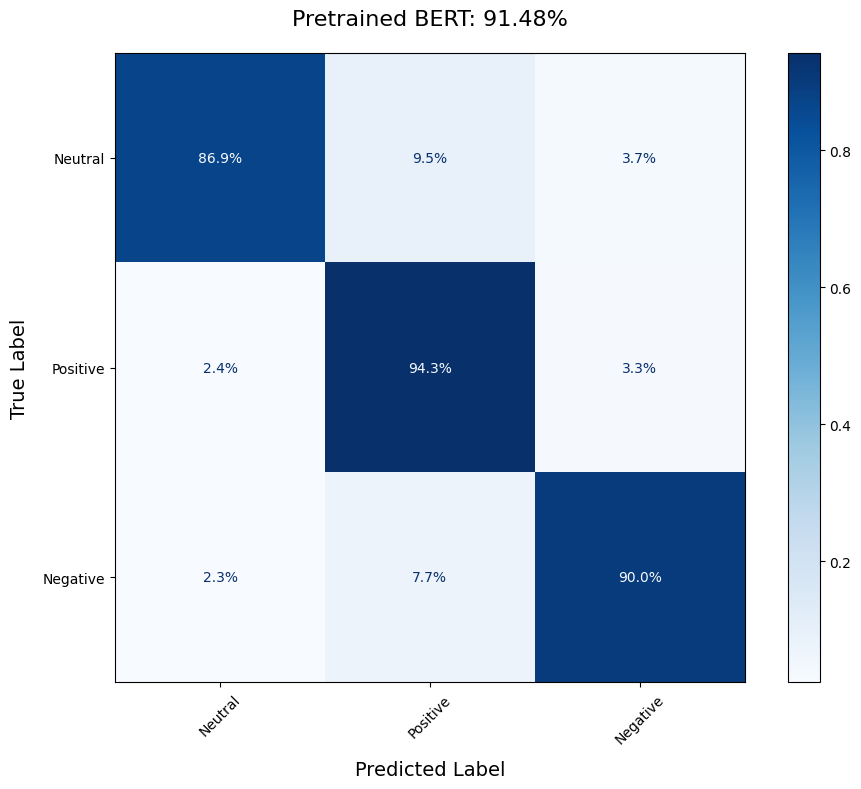

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# # FULL QUATFORMER
# conf_matrix = np.array([
#     [1642, 306, 146],
#     [104, 4702, 232],
#     [42, 312, 2518]
# ])

# # PARTIAL QUATFORMER
# conf_matrix = np.array([
#     [1644, 268, 182],
#     [137, 4544, 357],
#     [51, 224, 2597]
# ])

# PRETRAINED BERT - FROM OTHER NOTEBOOK
conf_matrix = np.array([
    [1819, 198, 77],
    [123, 4749, 166],
    [67, 221, 2584]
])

# Define class labels
class_labels = ['Neutral', 'Positive', 'Negative']

# Calculate accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

# Create a figure
plt.figure(figsize=(10, 8))

# Normalize the confusion matrix by row (true label)
row_sums = conf_matrix.sum(axis=1)
norm_conf_matrix = conf_matrix / row_sums[:, np.newaxis]

# Create the confusion matrix display
display = ConfusionMatrixDisplay(
    confusion_matrix=norm_conf_matrix,
    display_labels=class_labels
)

# Plot with enhanced styling
display.plot(
    cmap='Blues',           # Blue color map
    values_format='.1%',    # Show as percentages with 1 decimal place
    colorbar=True,          # Show color scale
    xticks_rotation=45,     # Rotate x labels for better readability
    ax=plt.gca()            # Get current axis
)

# Add title and adjust labels
plt.title(f'Pretrained BERT: {accuracy:.2%}', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)


# Improve layout
plt.tight_layout()

# Show the plot
plt.show()